## Testing what we can do with mewpy

https://mewpy.readthedocs.io/en/latest/main.html#:~:text=Metabolic%20Engineering%20Workbench%20in%20python,based%20models%20and%20simulation%20approaches.


https://mewpy.readthedocs.io/en/latest/simulation.html

Important for over and under expression of genes:
https://github.com/BioSystemsUM/mewpy/blob/master/examples/optimization.ipynb


In [3]:
#! pip install mewpy

In [4]:
# Load libraries
import numpy as np
from cobra.io import read_sbml_model, write_sbml_model
from cobra.util import create_stoichiometric_matrix
from cobra import Reaction, Metabolite
from cobra.core.gene import GPR

In [5]:
infilename = '../../models/iMM904_progesterone_fixed.xml'
print(f"Loading {infilename}")
model = read_sbml_model(infilename)

Loading ../../models/iMM904_progesterone_fixed.xml


In [6]:
#model.objective = model.reactions.R02216
#model.optimize().objective_value
#model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')


In [7]:
m = Metabolite("progesterone_e",formula="C21H30O2",name="EXprogesterone",compartment="e")

r = Reaction("T_progesterone")
model.add_reactions([r])
r.name = "T_progesterone"
r.lower_bound = 0.12698412
r.upper_bound = 1000
r.add_metabolites({"progesterone_c":-1,
                    m:1})
print(f'Adding reaction {r}')

model.add_boundary(model.metabolites.get_by_id('progesterone_e'), type='exchange')

Adding reaction T_progesterone: progesterone_c --> progesterone_e


Reaction identifier,EX_progesterone_e
Name,EXprogesterone exchange
Memory address,0x07f63faa633d0
Stoichiometry,progesterone_e <=> EXprogesterone <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [8]:
# build a phenotype simulator
from mewpy.simulation import get_simulator
simul = get_simulator(model)

In [9]:
simul.objective

{'BIOMASS_SC5_notrace': 1.0}

# Phenotype simulation

Phenotype simulations are also run using the simulator instance using the simulate method.

## Lots of stuff

In [10]:
simul.metabolites[:10]

['2dr5p_c',
 '2hb_c',
 '2hb_e',
 '2hhxdal_c',
 '2hp6mbq_m',
 '2hp6mp_m',
 '2hpmhmbq_m',
 '2hpmmbq_m',
 '2ippm_c',
 '2kmb_c']

In [11]:
simul.reactions[:10]


['CITtcp',
 '13BGH',
 '13BGHe',
 '13GS',
 '16GS',
 '23CAPPD',
 '2DDA7Ptm',
 '2DHPtm',
 '2DOXG6PP',
 '2HBO']

In [12]:
simul.compartments

{'c': 'cytosol',
 'e': 'extracellular space',
 'm': 'mitochondria',
 'x': 'peroxisome/glyoxysome',
 'r': 'endoplasmic reticulum',
 'v': 'vacuole',
 'g': 'golgi apparatus',
 'n': 'nucleus'}

In [13]:
# find reactions identified with a term containing 'biomass'
simul.find('biomass', find_in='m')

""


In [14]:
# find metabolites identified with a term containing 'o2'
simul.find('fadh',find_in='m')

,name,compartment,formula
id,,,
fadh2_m,Flavin adenine dinucleotide reduced,m,C27H33N9O15P2


A simulator may also be loaded considering environmental conditions, that will be considered during phenotype simulations. In the next example, glucose consumption is limited to 10 mmol/gDW/h while oxygen is set to unlimited.



In [17]:
# environmental conditions
envcond1 = {'EX_glc__D_e': (-50, 50),
           'EX_o2_e':(-5,5)}

envcond2 = {'EX_glc__D_e': (-0.000001, 100000.0),
           'EX_o2_e':(-1000,1000)}

envcond3 = {'EX_glc__D_e': (-100000.0, 100000.0),
           'EX_o2_e':(-10000000,0.0001)}

In [18]:
simul1 = get_simulator(model,envcond=envcond1)
result1 = simul1.simulate()
result1

objective: 1.1573827128273073
Status: OPTIMAL
Constraints: OrderedDict([('EX_glc__D_e', (-50, 50)), ('EX_o2_e', (-5, 5))])
Method:SimulationMethod.FBA

In [ ]:
simul2 = get_simulator(model,envcond=envcond2)
result2 = simul2.simulate()
result2

/home/trinebera/miniconda3/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


objective: 0.026629505994517272
Status: INFEASIBLE
Constraints: OrderedDict([('EX_glc__D_e', (-1e-06, 100000.0)), ('EX_o2_e', (-1000, 1000))])
Method:SimulationMethod.FBA

In [ ]:
simul3= get_simulator(model,envcond=envcond3)
result3 = simul3.simulate()
result3

objective: 9806.493729368463
Status: OPTIMAL
Constraints: OrderedDict([('EX_glc__D_e', (-100000.0, 100000.0)), ('EX_o2_e', (-10000000, 0.0001))])
Method:SimulationMethod.FBA

All phenotype simulations will consider the imposed environmental conditions, and as such they only need to be set once. Also, these conditions do not persistently alter the model, which can be reused with a different simulator instance.



In [53]:
# FBA 
result = simul.simulate(method='FBA')
result
# or 
# result1 = simul1.simulate(method='FBA')

#objective: 0.28786570370401676


objective: 0.28786570370401676
Status: OPTIMAL
Constraints: OrderedDict()
Method:FBA

Flux Balance Analysis (FBA) can be run without identifying any method, or by passing the ‘FBA’ as method parameter. Other phenotype simulation methods may also be run using one of the identifiers:

 - Flux Balance Analysis: method = 'FBA'
 - Parsimonious FBA:method = 'pFBA'
 - Minimization of Metabolic Adjustment:method = 'MOMA'
 - Linear MOMA: method = 'lMOMA'
 - Regulatory on/off minimization of metabolic flux: method = 'ROOM'

In [49]:
# pFBA
result = simul.simulate(method = 'pFBA')
result

objective: 11.64705882352941
Status: OPTIMAL
Constraints: OrderedDict()
Method:pFBA

In [50]:
result = simul.simulate(method = 'FBA')
result

objective: 0.0
Status: OPTIMAL
Constraints: OrderedDict()
Method:FBA

## Reaction fluxes

The phenotype simulation result object, besides containing the objective value and solver status, also include reaction fluxes in the form of a dictionary:

In [107]:
# FBA 
result = simul.simulate(method='FBA')
model.objective

In [ ]:
result.fluxes

It is also to possible to retrieve reaction fluxes in the form of a data frame:

In [ ]:
result.dataframe

In [20]:
# or using find to list specific fluxes ordered by their values
result1.find('BIOMASS_SC5_notrace|progesterone')

,Flux rate
Reaction ID,
BIOMASS_SC5_notrace,1.157383
T_progesterone,0.126984
EX_progesterone_e,0.126984


Individual reaction flux values can be obtained from the dictionary representation. For example, the Prephenate dehydratase reaction flux can be obtained from the previous pFBA simulation using the reaction identifier:

In [55]:
result.fluxes['R02216'] #intet progesterone produceres

0.0

In [56]:
result.fluxes['BIOMASS_SC5_notrace'] #men der produceres biomasse!

0.28786570370401676

## Retrieving and setting the model objective
The simulation objective, when running FBA or pFBA phenotype simulations, is, by default, the model objective which can be seen using the simulator.

In [9]:
# FBA 
result = simul.simulate(method='FBA')

In [10]:
simul.objective

{'BIOMASS_SC5_notrace': 1.0}

In [40]:
#simul.objective = 'ATPM'
# or
#simul.objective = {'R02216':1}

In [20]:
print('flux of extracellular progesterone:', result.fluxes['EX_progesterone_e']) #intet progesterone produceres
print('flux of biomass:', result.fluxes['BIOMASS_SC5_notrace']) #intet progesterone produceres

flux of extracellular progesterone: 0.12698412
flux of biomass: 0.14126793694328552


In [43]:
result2.fluxes['BIOMASS_SC5_notrace'] #men der produceres biomasse!

0.0

The simulator may also be used to change the model objective, for example, to optimize the ATP maintenance requirement (ATPM):

## Adding additional constraints to phenotype simulations
Simulations may include additional metabolic constraints on reaction fluxes. From the previous pFBA simulation one can observe that the organism does not produce L-tyrosine:

In [59]:
simul.objective

{'BIOMASS_SC5_notrace': 1.0}

In [62]:
result.fluxes['R02216']


0.0

Additional constraints may be added to the model so that the organism start to produce this aromatic amino acid. We may alter, for example, the 3-dehydroquinate dehydratase reaction bounds, among others, starting by verifying its initial bounds:

In [63]:
# initial bounds
simul.get_reaction_bounds('R02216')

(-999999.0, 999999.0)

In [68]:
constraints = {'R02216' : (0.01, 10000)}

In [72]:
constraints = {'R02216' : (0.01, 10000)}
result = simul.simulate(method='FBA',constraints=constraints)

result.fluxes['DM_progesterone_c']

0.01

We need to verify that the organism keeps groing

In [73]:
result.fluxes['BIOMASS_SC5_notrace']

0.2797166409344213

In [21]:
model.reactions.BIOMASS_SC5_notrace

Reaction identifier,BIOMASS_SC5_notrace
Name,Biomass SC5 notrace
Memory address,0x07f63eda34940
Stoichiometry,1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024... 1.1348 1 3 beta D Glucan C6H10O5 + 0.4588 L-Alanine + 0.046 AMP C10H12N5O7P + 0.1607 L-Arginine + 0.1017 L-Asparagine + 0.2975 L-Aspartate + 59.276 ATP C10H12N5O13P3 + 0.0447 CMP C9H12N3O8P +...
GPR,
Lower bound,0.0
Upper bound,999999.0


<AxesSubplot: xlabel='BIOMASS_SC5_notrace', ylabel='EX_progesterone_e'>

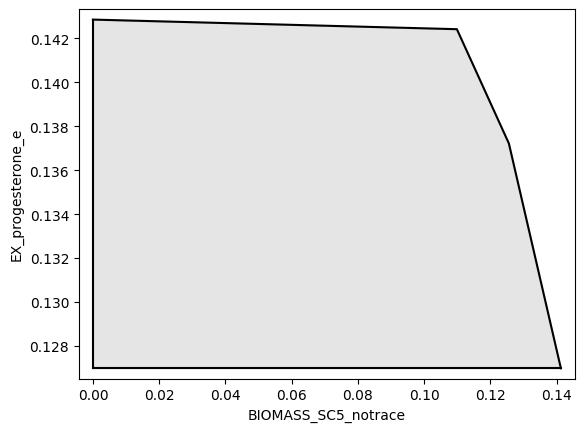

In [21]:
from mewpy.visualization.envelope import plot_flux_envelope
plot_flux_envelope(simul,'BIOMASS_SC5_notrace','EX_progesterone_e') #,constraints = constraints


## Flux Variability Analysis

The simulator interface also allows to perform Flux Variability Analysis (FVA) for L-tyrosine, returning a dictionary:

In [22]:
simul.FVA(reactions=['EX_progesterone_e'], format='df')
#{'DM_progesterone_c': [0.0, 0.031056490194959083]}

,Minimum,Maximum
Reaction ID,,
EX_progesterone_e,0.126984,0.136542


By default, MEWpy sets the model objective fraction to 90%, however this fraction may be altered. For example, one might want to consider a fraction of 10% from optimal growth:

In [24]:
simul.FVA(reactions=['EX_progesterone_e'], obj_frac=0.5, format='df')

,Minimum,Maximum
Reaction ID,,
EX_progesterone_e,0.126984,0.142576


The FVA simulations are run considering the defined environmental conditions. Additional constraints may be added, or changed, such as the ones previously used.


In [82]:
simul.FVA(reactions=['DM_progesterone_c'], constraints=constraints, format='df')


,Minimum,Maximum
Reaction ID,,
DM_progesterone_c,0.01,0.037104


COBRApy users may have noticed that this same task would have required many additional coding lines if using the COBRApy API directly.

## Essential genes

In [5]:
simul.essential_reactions()

#interesting: some ERG reactions are here:  'ERGSTter', 'ERGTETROLter',


100%|██████████| 1577/1577 [00:16<00:00, 97.48it/s] 


['13GS',
 'ACCOAC',
 'AGAT_SC',
 'AGPRim',
 'AHCi',
 'ACGKm',
 '2OXOADPtim',
 'ACHBSm',
 'ACLSm',
 'AICART',
 'AIRCr',
 'ACOTAim',
 'ACS',
 'ADSK',
 'ADSL1r',
 'ADSL2r',
 'ADSS',
 'ANPRT',
 'ANS',
 'C14STR',
 'C24STRer',
 'C3STDH1',
 'ARGSL',
 'ARGSS',
 'ASAD',
 'C3STDH2',
 'C3STKR1',
 'C3STKR2',
 'C4STMO1',
 'C4STMO2',
 'ASNS1',
 'ASPCT',
 'ASPK',
 'CBPS',
 '3MOBtm',
 'ATPPRT',
 'CHORM',
 'CHORS',
 'CO2tm',
 'CSm',
 'DESAT18_2',
 'DHAD1m',
 'DHAD2m',
 'DHFR',
 'DHORTS',
 'DHQS',
 'DHQTi',
 'DADK',
 'DMATT',
 'DOLPMMer',
 'DB4PS',
 'DOLPMTcer',
 'DOLPt2er',
 'DPMVD',
 'DROPPRy',
 'DRTPPD',
 'ERGSTter',
 'ERGTETROLter',
 '6PGLter',
 'EX_glc__D_e',
 'AATA',
 'EX_so4_e',
 'EX_nh4_e',
 'EX_o2_e',
 'EX_pi_e',
 'FAS100COA',
 'FAS120COA',
 'G5SADs',
 'GLUPRT',
 'G6PDH2er',
 'G6Pter',
 'FAS80COA_L',
 'GARFT',
 'GMPS2',
 'GND',
 'GRTT',
 'GLCt1',
 'GLNS',
 'GTPCII',
 'H2Oter',
 'HCITSm',
 'HACNHm',
 'HICITDm',
 'IMPC',
 'IMPD',
 'HISTD',
 'HISTP',
 'HMGCOAR',
 'IPDDI',
 'IPMD',
 'IPPMIa',
 'IPP

In [6]:
simul.essential_genes()

100%|██████████| 905/905 [00:12<00:00, 70.53it/s] 


['YCR034W',
 'YBR029C',
 'YDR487C',
 'YDR454C',
 'YJR016C',
 'YDR354W',
 'YER090W',
 'YKL211C',
 'YHR018C',
 'YOR236W',
 'YOL058W',
 'YKL216W',
 'YCR053W',
 'YDR127W',
 'YDR158W',
 'YGL154C',
 'YBR115C',
 'YJL167W',
 'YPL028W',
 'YNR016C',
 'YJL130C',
 'YER052C',
 'YER069W',
 'YMR062C',
 'YMR108W',
 'YCL009C',
 'YER055C',
 'YPR183W',
 'YKL182W',
 'YPL231W',
 'YNR043W',
 'YLR355C',
 'YBR153W',
 'YOL066C',
 'YOL140W',
 'YLR153C',
 'YDR226W',
 'YNL280C',
 'YHR042W',
 'YGL012W',
 'YGL001C',
 'YLR100W',
 'YGR060W',
 'YKL001C',
 'YLR359W',
 'YNL220W',
 'YER043C',
 'YGR037C',
 'YOR128C',
 'YPR060C',
 'YGL148W',
 'YMR217W',
 'YGR204W',
 'YOR130C',
 'YPR167C',
 'YBL033C',
 'YDR234W',
 'YGR157W',
 'YDR408C',
 'YIL094C',
 'YCL030C',
 'YFR025C',
 'YPR035W',
 'YML126C',
 'YER023W',
 'YJR139C',
 'YPR113W',
 'YHR025W',
 'YIL116W',
 'YMR300C',
 'YLR174W',
 'YBR248C',
 'YOR202W',
 'YFL045C',
 'YOR074C',
 'YJR148W',
 'YMR220W',
 'YDR074W',
 'YBR126C',
 'YNL316C',
 'YPL117C',
 'YGL026C',
 'YGL234W',
 'YD

## Strain optimization with mewpy

First analyze the media :D

In [9]:
from mewpy.simulation.environment import Environment
import pandas as pd

In [13]:
medium = Environment.from_model(model).get_compounds()
env = Environment.from_compounds(medium)
pd.DataFrame(env,index=['lb','ub']).T    #just making a dataframe with the medium. 
#lb = lower boundaries
#ub = upper boundaries

,lb,ub
EX_fe2_e,-10.0,inf
EX_glc__D_e,-10.0,inf
EX_h2o_e,-10.0,inf
EX_h_e,-10.0,inf
EX_k_e,-10.0,inf
EX_na1_e,-10.0,inf
EX_so4_e,-10.0,inf
EX_nh4_e,-10.0,inf
EX_o2_e,-10.0,inf
EX_pi_e,-10.0,inf


## Upregulating genes with mewpy

In [3]:
%matplotlib inline
from cobra.io.sbml import read_sbml_model
model = read_sbml_model("e_coli_core.xml.gz")

In [5]:
model

Name,e_coli_core
Memory address,0x07fb63a189fa0
Number of metabolites,72
Number of reactions,95
Number of groups,9
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"cytosol, extracellular space"


## Optimization problem

Before running any optimization let us verify the production rate as well as the theoretic maximum rate of succinate in anaerobic conditions. To ease the script reutilization we will define some reaction identifiers as constants:

In [39]:
#model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')

Reaction identifier,DM_progesterone_c
Name,progesterone demand
Memory address,0x07fe1410ddf40
Stoichiometry,progesterone_c --> progesterone -->
GPR,
Lower bound,0
Upper bound,1000.0


In [40]:
model.objective = model.reactions.DM_progesterone_c
model.optimize().objective_value

0.14285714285714285

In [41]:
model.objective = model.reactions.R02216
model.optimize().objective_value

0.14285714285714285

In [46]:
simul = get_simulator(model)

In [47]:
result = simul.simulate(method='FBA')
result

objective: 0.14285714285714285
Status: OPTIMAL
Constraints: OrderedDict()
Method:FBA

In [22]:
BIOMASS = 'BIOMASS_SC5_notraceM'
PRODUCT = 'DM_progesterone_c' #R02216
O2 = 'EX_o2_e'
GLC = 'EX_glc__D_e'

In [25]:
anaerobic = {O2: (-1000, 1000)}

In [26]:
from mewpy.simulation import get_simulator
sim = get_simulator(model,envcond=anaerobic)
sim.FVA(reactions=[PRODUCT],format='df')

#Hvad betyder minimum og maximum her????

,Minimum,Maximum
Reaction ID,,
DM_progesterone_c,0.888198,0.986887


In [27]:
sim.simulate(method='pFBA').find([BIOMASS,PRODUCT])

,Flux rate
Reaction ID,
DM_progesterone_c,0.986887


The optimization problem requires the definition of one or more objective functions. In the next example, we define as objective the maximization of the Biomass-Product coupled yield and the maximization of the targeted product. MEWpy makes available other optimization objectives, please refer to the documentation.

In [28]:
from mewpy.optimization.evaluation import BPCY, TargetFlux

objs = [ 
    BPCY(BIOMASS, PRODUCT),
    TargetFlux(PRODUCT)
]

We can now define the growth medium and select the type of modification. We will begin by performing gene deletion (GKO) by selecting the appropriate problem instance, GKOProblem.



In [30]:
from mewpy.problems import GKOProblem, GOUProblem

problem = GOUProblem(model, objs, envcond=anaerobic, candidate_max_size=6)

Other optimization methods/strategies may be used:
 - Reaction deletion: RKOProblem
 - Reaction under or over expression: ROUProblem
 - Gene under or over expression: GOUProblem

A problem may include other parameters, such as the maximum number of genetic modification, a list of specitic targets, or non-targets (reactions/genes not to be modified).

## Optimization algorithm

An optimization engine to solve the problem need to be instanciated. MEWpy uses Evolutionary Algorithms (EA) for this task.

EAs are algorithms that mimic the Darwinian evolutionary process, where a population of solutions evolves generation after generation. In the example we define a maximum of 50 generations.

In [31]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=50)
# type help(EA) for more information

The EA may contemplate aditional parameters such as the identification of a specific algorithm (e.g. SPEA2, NSGAII, NSGAIII, GDE3, etc.), multiprocessing options, initial seeding, etc.

To start the optimization process invoke the run method:

In [33]:
solutions = ea.run()

Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    200|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    300|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    400|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    500|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    600|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    700|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
    800|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.0000

SystemExit: 0

/home/trinebera/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


We can now list the set of solutions:

In [34]:
df=ea.dataframe()
df

Exception: No solutions

Or view the best solutions on the objective space, the so called Pareto front:



In [ ]:
ea.plot()

# Strain optimization

OBS! Here the code get's outdated. Therefore, change to this tutorial: https://github.com/BioSystemsUM/mewpy/blob/master/examples/optimization.ipynb

MEWpy is a Computational Stain Optimization framework that uses Evolutionary Computation to find sets of metabolic modifications to favor a defined target. Optimization tasks are defined as optimization problems which encompass a metabolic model and optimization objectives. Additional arguments may be added depending on the problem specificities.

